# How will customer segmentation improve my business? 
* Better identify your most valuable customer segments
* Improve your return on marketing investment by only targeting those likely to be your best customers
* Increase customer loyalty by tailoring your services to your best customers
* Improve customer service
* Positively impact revenue and reduce waste across your organization

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from pandas_profiling import ProfileReport
import plotly.express as px


In [39]:
df=pd.read_excel('retail.xlsx')


In [40]:
data = ff.create_table(df.head())
data

In [41]:
profile = ProfileReport(df, title="Retail data",explorative=True)
profile

In [42]:
profile.to_widgets()

In [43]:
profile.to_file('your_report_name.html')

In [44]:
#Customer distribution by country
country_cust_data=df[['Country','CustomerID']].drop_duplicates()
data=country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
data = ff.create_table(data.head(6))
data

In [45]:
#Keep only United Kingdom data
data =df.query("Country=='United Kingdom'").reset_index(drop=True)

In [46]:

#Remove missing values from CustomerID column, can ignore missing values in description column
data = data[pd.notnull(data['CustomerID'])]

#Validate if there are any negative values in Quantity column
data.Quantity.min()

-80995

In [47]:

#Filter out records with negative values
data = data[(data['Quantity']>0)]

In [48]:
#Convert the string date field to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [49]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [50]:

#Add new column depicting total amount
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34

# RFM Modelling

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

RFM stands for the three dimensions:

* Recency – How recently did the customer purchase?
* Frequency – How often do they purchase?
* Monetary Value – How much do they spend?

In [51]:
#Recency = Latest Date - Last Inovice Data,
#Frequency = count of invoice no. of transaction(s),
#Monetary = Sum of Total Amount for each customer

import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()
data = ff.create_table(RFMScores.reset_index().head())

In [52]:
data

In [53]:
#Recency distribution plot
fig = px.histogram(RFMScores, x="Recency")
fig.show()

In [54]:
#Frequency distribution plot, taking observations which have frequency less than 1000
x = RFMScores.query('Frequency < 1000')['Frequency']
fig = px.histogram(RFMScores, x=x)
fig.show()

In [55]:
#Monateray distribution plot, taking observations which have monetary value less than 100
x = RFMScores.query('Monetary < 1000')['Monetary']
fig = px.histogram(RFMScores, x=x)
fig.show()

In [56]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [57]:
#Functions to create R, F and M segments
# use quintiles to divide customers into  4segments. 
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [58]:

#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()


Recency  Frequency  Monetary  R  F  M
CustomerID                                       
12346.0         325          1  77183.60  4  4  1
12747.0           2        103   4196.01  1  1  1
12748.0           0       4596  33719.73  1  1  1
12749.0           3        199   4090.88  1  1  1
12820.0           3         59    942.34  1  2  2

In [59]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()


Recency  Frequency  Monetary  R  F  M RFMGroup  RFMScore
CustomerID                                                          
12346.0         325          1  77183.60  4  4  1      441         9
12747.0           2        103   4196.01  1  1  1      111         3
12748.0           0       4596  33719.73  1  1  1      111         3
12749.0           3        199   4090.88  1  1  1      111         3
12820.0           3         59    942.34  1  2  2      122         5

In [60]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

CustomerID  Recency  Frequency  Monetary  R  F  M RFMGroup  RFMScore  \
0     12346.0      325          1  77183.60  4  4  1      441         9   
1     12747.0        2        103   4196.01  1  1  1      111         3   
2     12748.0        0       4596  33719.73  1  1  1      111         3   
3     12749.0        3        199   4090.88  1  1  1      111         3   
4     12820.0        3         59    942.34  1  2  2      122         5   

  RFM_Loyalty_Level  
0            Silver  
1          Platinum  
2          Platinum  
3          Platinum  
4          Platinum

In [61]:

import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Recency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


# K-Means Clustering

In [62]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [63]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
#ax = sns.distplot(Recency_Plot)

fig = px.histogram(RFMScores, x=Recency_Plot)
fig.show()

In [64]:
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
fig = px.histogram(RFMScores, x=Frequency_Plot)
fig.show()

In [65]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
fig = px.histogram(RFMScores, x=Monetary_Plot)
fig.show()

In [66]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

In [67]:
Scaled_Data.head()

Recency  Frequency  Monetary
CustomerID                               
12346.0     1.389971  -2.733639  3.766415
12747.0    -2.061189   0.726978  1.439009
12748.0    -2.530970   3.562667  3.104639
12749.0    -1.785964   1.218258  1.419028
12820.0    -1.785964   0.311106  0.244935

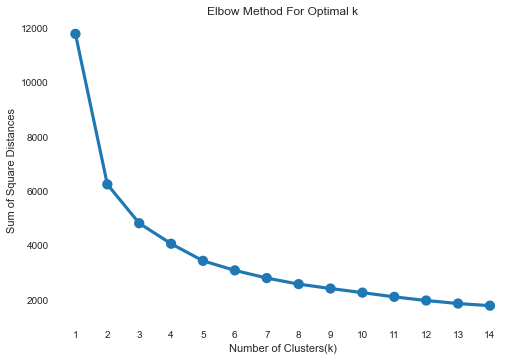

In [68]:
from sklearn.cluster import KMeans
import seaborn as sns 

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [69]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

Recency  Frequency  Monetary  R  F  M RFMGroup  RFMScore  \
CustomerID                                                             
12346.0         325          1  77183.60  4  4  1      441         9   
12747.0           2        103   4196.01  1  1  1      111         3   
12748.0           1       4596  33719.73  1  1  1      111         3   
12749.0           3        199   4090.88  1  1  1      111         3   
12820.0           3         59    942.34  1  2  2      122         5   

           RFM_Loyalty_Level  Cluster  
CustomerID                             
12346.0               Silver        0  
12747.0             Platinum        2  
12748.0             Platinum        2  
12749.0             Platinum        2  
12820.0             Platinum        2

<Figure size 504x504 with 0 Axes>

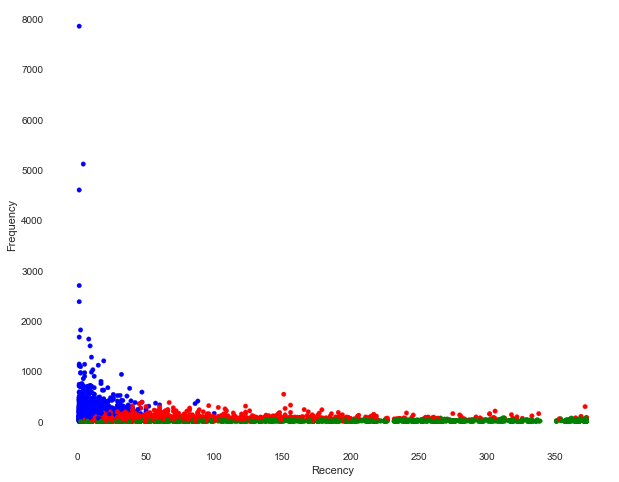

In [70]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)

In [71]:
RFMScores.head()

Recency  Frequency  Monetary  R  F  M RFMGroup  RFMScore  \
CustomerID                                                             
12346.0         325          1  77183.60  4  4  1      441         9   
12747.0           2        103   4196.01  1  1  1      111         3   
12748.0           1       4596  33719.73  1  1  1      111         3   
12749.0           3        199   4090.88  1  1  1      111         3   
12820.0           3         59    942.34  1  2  2      122         5   

           RFM_Loyalty_Level  Cluster Color  
CustomerID                                   
12346.0               Silver        0   red  
12747.0             Platinum        2  blue  
12748.0             Platinum        2  blue  
12749.0             Platinum        2  blue  
12820.0             Platinum        2  blue

# Hierarchial Clustering¶¶

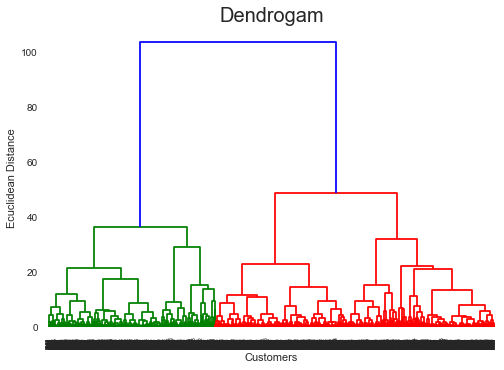

In [72]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(Scaled_Data, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

In [73]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(Scaled_Data)
y_hc 

array([1, 1, 1, ..., 0, 3, 3], dtype=int64)